In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [3]:
# 1. Load data
df = pd.read_csv('Traffic.csv')

In [4]:
# 2. Feature engineering: Binary target for 'Traffic Situation'
df['Target'] = df['Traffic Situation'].apply(lambda x: 1 if x in ['heavy', 'high'] else 0)

In [5]:
# 3. Handle missing values
def fill_missing(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col].fillna(df[col].mode()[0], inplace=True)
        else:
            df[col].fillna(df[col].median(), inplace=True)
    return df

df = fill_missing(df)

In [6]:
# 4. One-hot encode categorical features (except target)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in ['Traffic Situation']]
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [7]:
# 5. Drop non-numeric columns before modeling
non_numeric_cols = df.select_dtypes(include=['object']).columns.tolist()
df = df.drop(non_numeric_cols, axis=1)

In [8]:
# 5b. Feature selection - remove highly correlated features
corr_matrix = df.corr().abs()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
tri_df = corr_matrix.mask(mask)
to_drop = [x for x in tri_df.columns if any(tri_df[x] > 0.95)]
df = df.drop(to_drop, axis=1)
print(f"\nFeatures after correlation removal: {df.shape[1]}")
print(f"Removed features: {to_drop}")


Features after correlation removal: 107
Removed features: ['CarCount']


* This tells us that 1 feature (CarCount) was removed because it had a correlation higher than 0.95 with another feature.

* After removal, the dataset now contains 107 features.

This output confirms that the dataset has been streamlined to improve model performance and reduce overfitting.

In [9]:
# 6. Feature/target split
X = df.drop('Target', axis=1)
y = df['Target']

In [10]:
# 7. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
# 7b. Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(f"\nOriginal training set shape: {X_train.shape}")
print(f"Resampled training set shape: {X_train_resampled.shape}")
print(f"Resampled training set target distribution:")
print(pd.Series(y_train_resampled).value_counts(normalize=True))


Original training set shape: (2380, 106)
Resampled training set shape: (3156, 106)
Resampled training set target distribution:
Target
0    0.5
1    0.5
Name: proportion, dtype: float64


* Originally, the training set had 2,380 samples and 106 features.

* After applying SMOTE, the number of training samples increased to 3,156, showing that synthetic samples were added to balance the classes.

* The new target distribution is perfectly balanced: 50% class 0 and 50% class 1.

This confirms that SMOTE successfully addressed the class imbalance, which helps improve model fairness and performance, especially for the minority class.

In [12]:
# 8. Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [13]:
# 9. Baseline SVM
svm = SVC(probability=True, random_state=42)
svm.fit(X_train_scaled, y_train_resampled)
y_pred = svm.predict(X_test_scaled)

In [14]:
# 10. Evaluation function
def evaluate(y_true, y_pred, model_name="Model"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"\n=== {model_name} Evaluation ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    if model_name == "SVM (Baseline)":
        baseline_report_text = classification_report(y_true, y_pred)
        with open('svm_classification_report.txt', 'w') as f:
            f.write('=== BASELINE CLASSIFICATION REPORT ===\n')
            f.write(baseline_report_text + '\n\n')
    if model_name == "SVM (Tuned)":
        tuned_report_text = classification_report(y_true, y_pred)
        with open('svm_classification_report.txt', 'a') as f:
            f.write('=== TUNED CLASSIFICATION REPORT ===\n')
            f.write(tuned_report_text + '\n')
    return acc, prec, rec, f1

# Baseline evaluation
baseline_metrics = evaluate(y_test, y_pred, model_name="SVM (Baseline)")


=== SVM (Baseline) Evaluation ===
Accuracy: 0.8926
Precision: 0.8442
Recall: 0.8358
F1-score: 0.8400

Confusion Matrix:
[[364  31]
 [ 33 168]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       395
           1       0.84      0.84      0.84       201

    accuracy                           0.89       596
   macro avg       0.88      0.88      0.88       596
weighted avg       0.89      0.89      0.89       596



The output shows that the baseline SVM model achieved an accuracy of 89.26% on the test set. It had a precision of 84.42%, meaning most of its positive predictions were correct, and a recall of 83.58%, indicating it correctly identified most actual positive cases. The F1-score of 84.00% shows a good balance between precision and recall. The confusion matrix indicates that 364 non-congested and 168 congested traffic instances were correctly predicted, while 31 and 33 were misclassified, respectively. Overall, the model performed well across both classes.

In [15]:
# 11. Hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}
gs = GridSearchCV(SVC(probability=True, random_state=42), param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=1)
gs.fit(X_train_scaled, y_train_resampled)
print(f"\nBest parameters: {gs.best_params_}")

Fitting 3 folds for each of 18 candidates, totalling 54 fits

Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}


* The model tested 18 parameter combinations using 3-fold cross-validation.

* The best-performing configuration is:

  * C = 10: stronger regularization,

  * gamma = 'scale': automatic setting based on feature values,

  * kernel = 'linear': linear decision boundary.

This step identifies the optimal settings for improved model performance.

In [16]:
# 12. Tuned model evaluation
y_pred_tuned = gs.predict(X_test_scaled)
tuned_metrics = evaluate(y_test, y_pred_tuned, model_name="SVM (Tuned)")


=== SVM (Tuned) Evaluation ===
Accuracy: 0.9497
Precision: 0.9014
Recall: 0.9552
F1-score: 0.9275

Confusion Matrix:
[[374  21]
 [  9 192]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       395
           1       0.90      0.96      0.93       201

    accuracy                           0.95       596
   macro avg       0.94      0.95      0.94       596
weighted avg       0.95      0.95      0.95       596



Output Summary:

* Accuracy: 94.97% - a significant improvement from the baseline.

* Precision: 90.14% - more accurate positive predictions.

* Recall: 95.52% - most actual positives were correctly identified.

* F1-score: 92.75% - strong balance between precision and recall.

Confusion Matrix:

* Only 30 misclassifications out of 596 samples.

* Much better class balance compared to baseline.

Overall, the tuned SVM model performs substantially better than the baseline, especially in identifying congested traffic cases (class 1).

Cross-validation F1 scores: [0.93333333 0.94753577 0.95433071 0.97515528 0.97230769]
Mean CV F1 score: 0.9565 (+/- 0.0312)
Cross-validation Accuracy: 0.9563 (+/- 0.0305)


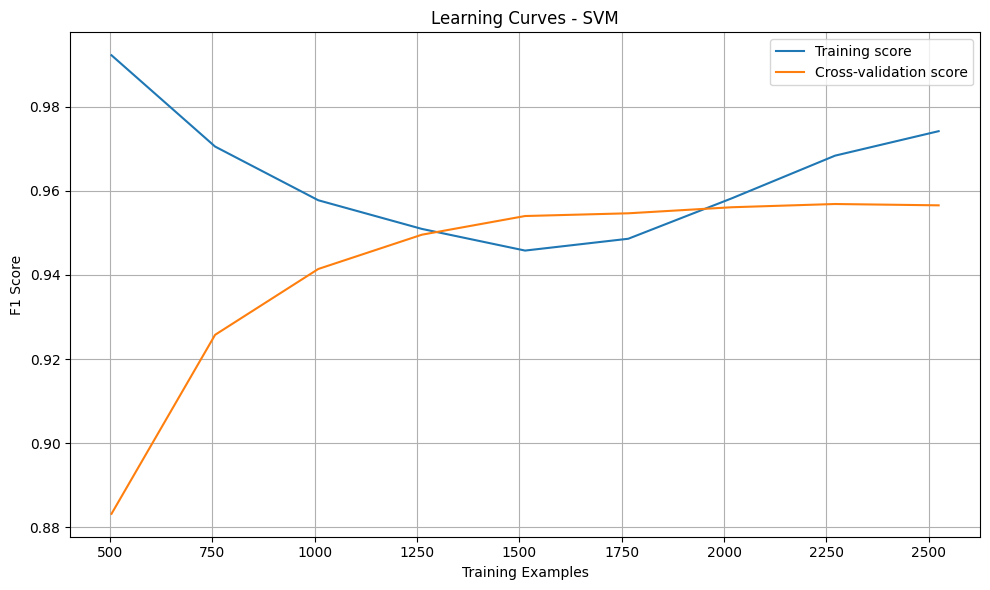

In [17]:
# 12b. Cross-validation and model stability
cv_scores = cross_val_score(gs.best_estimator_, X_train_scaled, y_train_resampled, cv=5, scoring='f1')
print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Mean CV F1 score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
cv_acc_scores = cross_val_score(gs.best_estimator_, X_train_scaled, y_train_resampled, cv=5, scoring='accuracy')
print(f"Cross-validation Accuracy: {cv_acc_scores.mean():.4f} (+/- {cv_acc_scores.std() * 2:.4f})")

# Learning curves
train_sizes, train_scores, val_scores = learning_curve(
    gs.best_estimator_, X_train_scaled, y_train_resampled, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='f1'
)
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Cross-validation score')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.title('Learning Curves - SVM')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('svm_learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()

The learning curve visualization illustrates how the Support Vector Machine (SVM) model's performance changes as the number of training examples increases. The plot shows two lines: one for the training F1 score and another for the cross-validation F1 score. A high training score paired with a lower validation score suggests overfitting, while closely aligned curves indicate a well-generalized model. In this case, the graph helps assess whether the model benefits from more data and how stable it is across different sample sizes. It also complements the printed cross-validation results, providing a visual insight into model stability and learning efficiency.

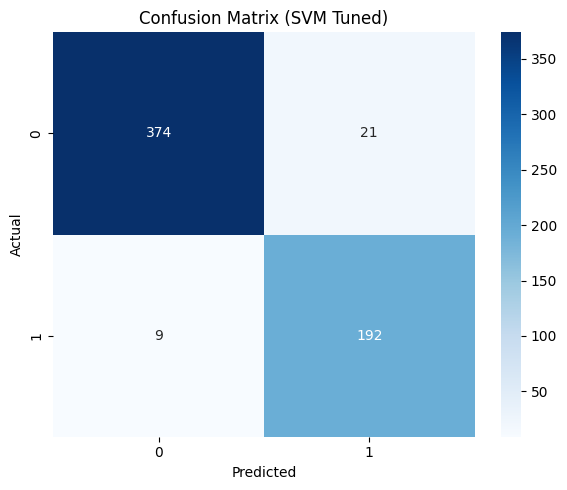

In [18]:
# 13. Confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (SVM Tuned)')
plt.tight_layout()
plt.savefig('svm_confusion_matrix.png', dpi=300)
plt.show()

The heatmap visualizes the confusion matrix for the tuned SVM model, showing how well the model classified the test data. The matrix displays the counts of correct and incorrect predictions: true positives and true negatives appear on the diagonal, while off-diagonal values represent misclassifications. The color intensity helps highlight areas with more predictions. A strong model will show darker cells along the diagonal and lighter cells elsewhere. This plot provides a quick overview of the model’s accuracy and its performance on each class.

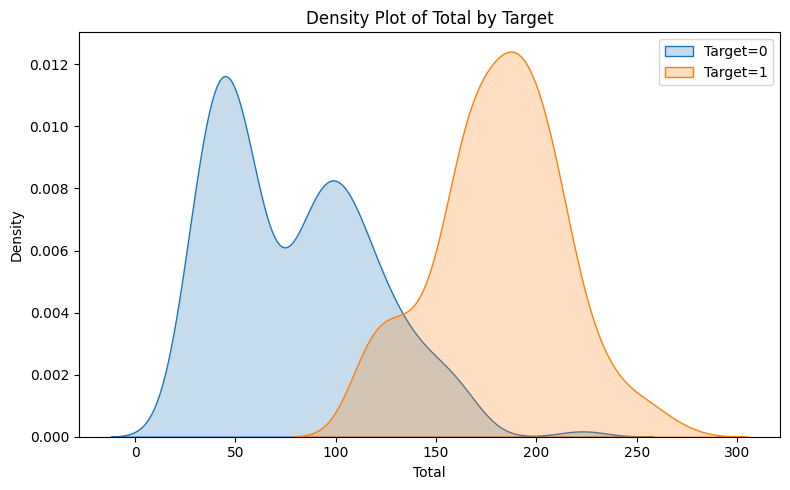


All visualizations have been saved as PNG files.

COMPARISON: BASELINE VS TUNED SVM

Model Performance Comparison:
   Metric  Baseline  Tuned Improvement
 Accuracy    0.8926 0.9497     +0.0570
Precision    0.8442 0.9014     +0.0572
   Recall    0.8358 0.9552     +0.1194
 F1-Score    0.8400 0.9275     +0.0875

Comparison table saved to 'svm_comparison.csv'


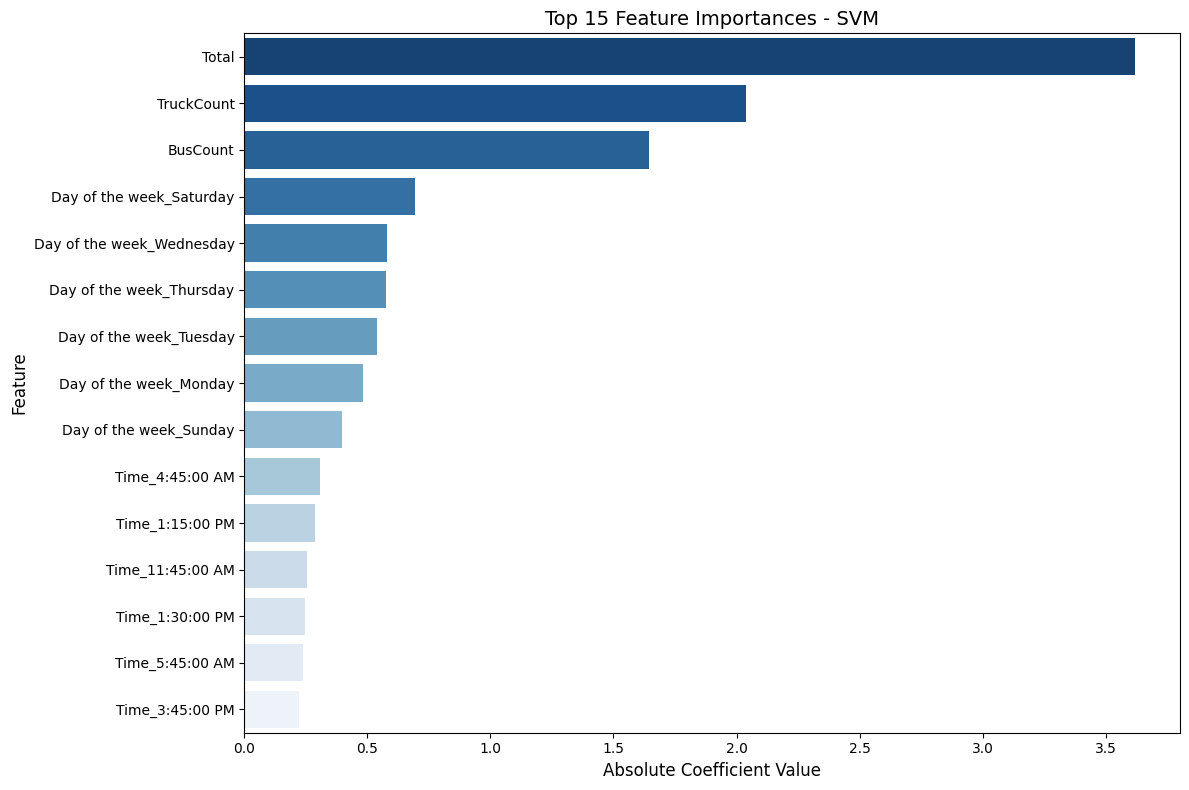


ACCURACY TABLE: BASELINE VS TUNED SVM
          Metrics Before Tuning After Tuning
Training accuracy        0.9477       0.9728
 Testing accuracy        0.8926       0.9497
          ROC AUC        0.9624       0.9835


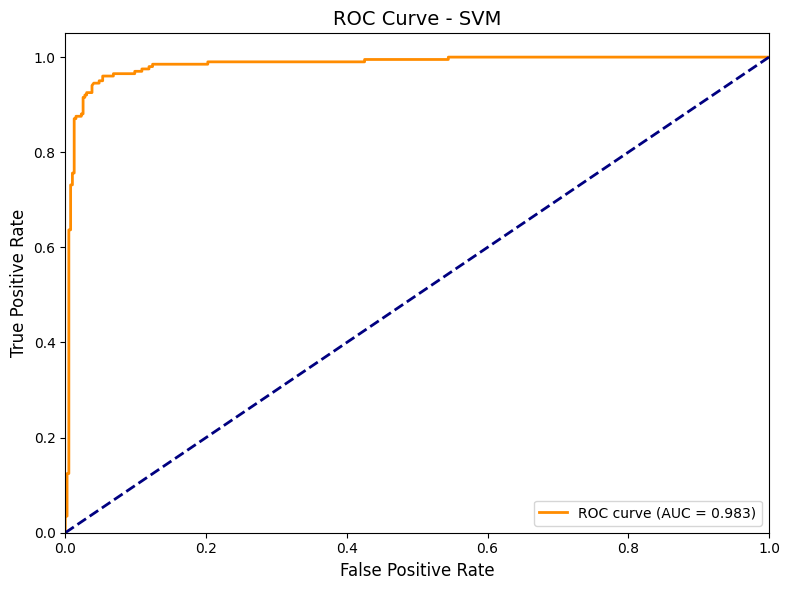

In [19]:
# 14. Density plot for a key feature (if exists)
if 'Total' in X.columns:
    plt.figure(figsize=(8, 5))
    for label in [0, 1]:
        sns.kdeplot(X_test['Total'][y_test == label], label=f'Target={label}', fill=True)
    plt.title('Density Plot of Total by Target')
    plt.xlabel('Total')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.savefig('svm_density_total.png', dpi=300)
    plt.show()

print("\nAll visualizations have been saved as PNG files.")

# Add comparison table after tuned model evaluation
print("\n" + "="*60)
print("COMPARISON: BASELINE VS TUNED SVM")
print("="*60)

# Get all metrics for both models
baseline_acc = accuracy_score(y_test, y_pred)
baseline_prec = precision_score(y_test, y_pred)
baseline_rec = recall_score(y_test, y_pred)
baseline_f1 = f1_score(y_test, y_pred)

tuned_acc = accuracy_score(y_test, y_pred_tuned)
tuned_prec = precision_score(y_test, y_pred_tuned)
tuned_rec = recall_score(y_test, y_pred_tuned)
tuned_f1 = f1_score(y_test, y_pred_tuned)

# Create and display comparison table
comparison_table = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Baseline': [baseline_acc, baseline_prec, baseline_rec, baseline_f1],
    'Tuned': [tuned_acc, tuned_prec, tuned_rec, tuned_f1],
    'Improvement': [tuned_acc - baseline_acc, tuned_prec - baseline_prec,
                   tuned_rec - baseline_rec, tuned_f1 - baseline_f1]
})

# Format the table
comparison_table = comparison_table.round(4)
comparison_table['Improvement'] = comparison_table['Improvement'].apply(lambda x: f"{'+' if x >= 0 else ''}{x:.4f}")

print("\nModel Performance Comparison:")
print(comparison_table.to_string(index=False))

# Save comparison to CSV
comparison_table.to_csv('svm_comparison.csv', index=False)
print("\nComparison table saved to 'svm_comparison.csv'")

# Standardized Feature Importance Plot for SVM (if linear kernel)
if hasattr(gs.best_estimator_, 'coef_'):
    importances = abs(gs.best_estimator_.coef_[0])
    indices = np.argsort(importances)[::-1]
    feature_importance = pd.DataFrame({
        'feature': X.columns[indices],
        'importance': importances[indices]
    })
    plt.figure(figsize=(12, 8))
    sns.barplot(data=feature_importance.head(15), x='importance', y='feature', palette='Blues_r')
    plt.title('Top 15 Feature Importances - SVM', fontsize=14)
    plt.xlabel('Absolute Coefficient Value', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.savefig('svm_feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

# Show training and testing accuracy table before and after tuning, including ROC AUC
train_acc_baseline = accuracy_score(y_train_resampled, svm.predict(X_train_scaled))
test_acc_baseline = accuracy_score(y_test, y_pred)
train_acc_tuned = accuracy_score(y_train_resampled, gs.predict(X_train_scaled))
test_acc_tuned = accuracy_score(y_test, y_pred_tuned)

# ROC AUC (use predict_proba)
roc_auc_baseline = roc_auc_score(y_test, svm.predict_proba(X_test_scaled)[:, 1])
roc_auc_tuned = roc_auc_score(y_test, gs.predict_proba(X_test_scaled)[:, 1])

acc_table = pd.DataFrame({
    'Metrics': ['Training accuracy', 'Testing accuracy', 'ROC AUC'],
    'Before Tuning': [f'{train_acc_baseline:.4f}', f'{test_acc_baseline:.4f}', f'{roc_auc_baseline:.4f}'],
    'After Tuning': [f'{train_acc_tuned:.4f}', f'{test_acc_tuned:.4f}', f'{roc_auc_tuned:.4f}']
})
print("\n" + "="*60)
print("ACCURACY TABLE: BASELINE VS TUNED SVM")
print("="*60)
print(acc_table.to_string(index=False))

# ROC Curve Visualization for Tuned Model
svm_pred_proba = gs.predict_proba(X_test_scaled)[:, 1]
svm_roc_auc = roc_auc_score(y_test, svm_pred_proba)
fpr, tpr, _ = roc_curve(y_test, svm_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {svm_roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - SVM', fontsize=14)
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('svm_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

1. Density Plot of Total by Target
This plot shows the distribution of the Total vehicle count for each class of the target variable (0 and 1). Each curve represents a class, and the filled area shows how frequently different Total values occur. Clear separation between the curves suggests the Total feature is useful for distinguishing between light and heavy traffic. Overlap indicates some ambiguity, but still offers insight into class differences.

2. Feature Importance Plot (SVM with Linear Kernel)
This horizontal bar plot displays the top 15 most influential features in the SVM model with a linear kernel. Feature importance is measured by the absolute value of model coefficients — the higher the value, the more impact the feature has on classification. This plot helps us understand which input variables contributed most to the model's decision-making process.

3. ROC Curve - Tuned SVM Model
The ROC curve shows the trade-off between true positive rate (sensitivity) and false positive rate across different thresholds. The curve for the tuned SVM model is plotted alongside a diagonal reference line representing random guessing. The AUC (Area Under the Curve) value quantifies how well the model distinguishes between the classes — values closer to 1 indicate better performance. A high AUC confirms strong classification ability.